# Plotting SWR Process Results

This notebook demonstrates the use of the `SwrObs` and `SwrStage`, `SwrBudget`, `SwrFlow`, and `SwrExchange`, `SwrStructure`,  classes to read binary SWR Process observation, stage, budget, reach to reach flows, reach-aquifer exchange, and structure files. It demonstrates these capabilities by loading these binary file types and showing examples of plotting SWR Process data. An example showing how the simulated water surface profile at a selected time along a selection of reaches can be plotted is also presented.

In [1]:
from IPython.display import Image
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
numpy version: 1.24.2
matplotlib version: 3.6.3
flopy version: 3.3.7


In [2]:
# Set the paths
datapth = os.path.join("..", "..", "examples", "data", "swr_test")

# SWR Process binary files
files = ("SWR004.obs", "SWR004.vel", "SWR004.str", "SWR004.stg", "SWR004.flow")

### Load SWR Process observations

Create an instance of the `SwrObs` class and load the observation data.

In [3]:
sobj = flopy.utils.SwrObs(os.path.join(datapth, files[0]))

ts = sobj.get_data()

#### Plot the data from the binary SWR Process observation file

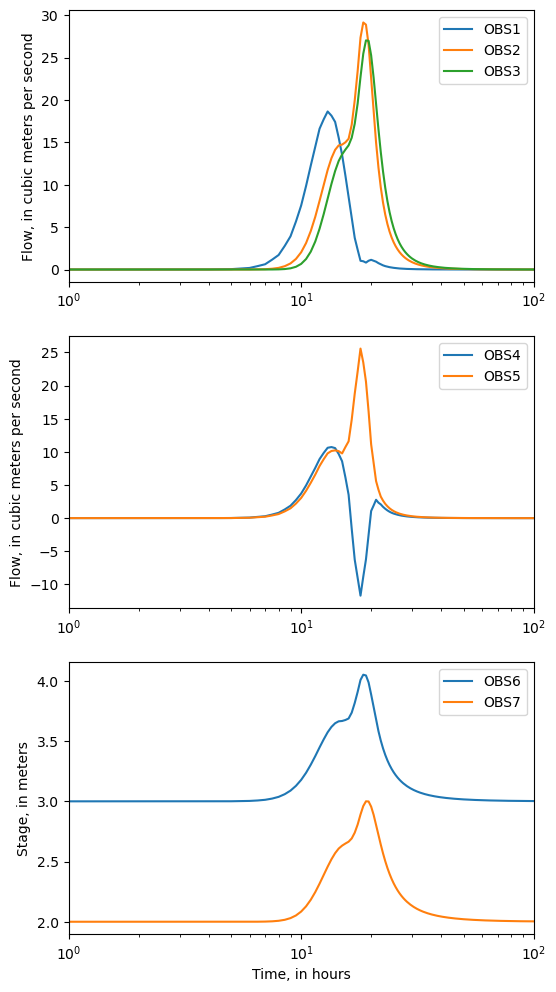

In [4]:
fig = plt.figure(figsize=(6, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.semilogx(ts["totim"] / 3600.0, -ts["OBS1"], label="OBS1")
ax1.semilogx(ts["totim"] / 3600.0, -ts["OBS2"], label="OBS2")
ax1.semilogx(ts["totim"] / 3600.0, -ts["OBS9"], label="OBS3")
ax1.set_ylabel("Flow, in cubic meters per second")
ax1.legend()

ax = fig.add_subplot(3, 1, 2, sharex=ax1)
ax.semilogx(ts["totim"] / 3600.0, -ts["OBS4"], label="OBS4")
ax.semilogx(ts["totim"] / 3600.0, -ts["OBS5"], label="OBS5")
ax.set_ylabel("Flow, in cubic meters per second")
ax.legend()

ax = fig.add_subplot(3, 1, 3, sharex=ax1)
ax.semilogx(ts["totim"] / 3600.0, ts["OBS6"], label="OBS6")
ax.semilogx(ts["totim"] / 3600.0, ts["OBS7"], label="OBS7")
ax.set_xlim(1, 100)
ax.set_ylabel("Stage, in meters")
ax.set_xlabel("Time, in hours")
ax.legend();

### Load the same data from the individual binary SWR Process files

Load discharge data from the flow file. The flow file contains the simulated flow between connected reaches for each connection in the model.

In [5]:
sobj = flopy.utils.SwrFlow(os.path.join(datapth, files[1]))
times = np.array(sobj.get_times()) / 3600.0
obs1 = sobj.get_ts(irec=1, iconn=0)
obs2 = sobj.get_ts(irec=14, iconn=13)
obs4 = sobj.get_ts(irec=4, iconn=3)
obs5 = sobj.get_ts(irec=5, iconn=4)

Load discharge data from the structure file. The structure file contains the simulated structure flow for each reach with a structure.

In [6]:
sobj = flopy.utils.SwrStructure(os.path.join(datapth, files[2]))
obs3 = sobj.get_ts(irec=17, istr=0)

Load stage data from the stage file. The flow file contains the simulated stage for each reach in the model.

In [7]:
sobj = flopy.utils.SwrStage(os.path.join(datapth, files[3]))
obs6 = sobj.get_ts(irec=13)

Load budget data from the budget file. The budget file contains the simulated budget for each reach group in the model. The budget file also contains the stage data for each reach group. In this case the number of reach groups equals the number of reaches in the model.

In [8]:
sobj = flopy.utils.SwrBudget(os.path.join(datapth, files[4]))
obs7 = sobj.get_ts(irec=17)

#### Plot the data loaded from the individual binary SWR Process files.

Note that the plots are identical to the plots generated from the binary SWR observation data.

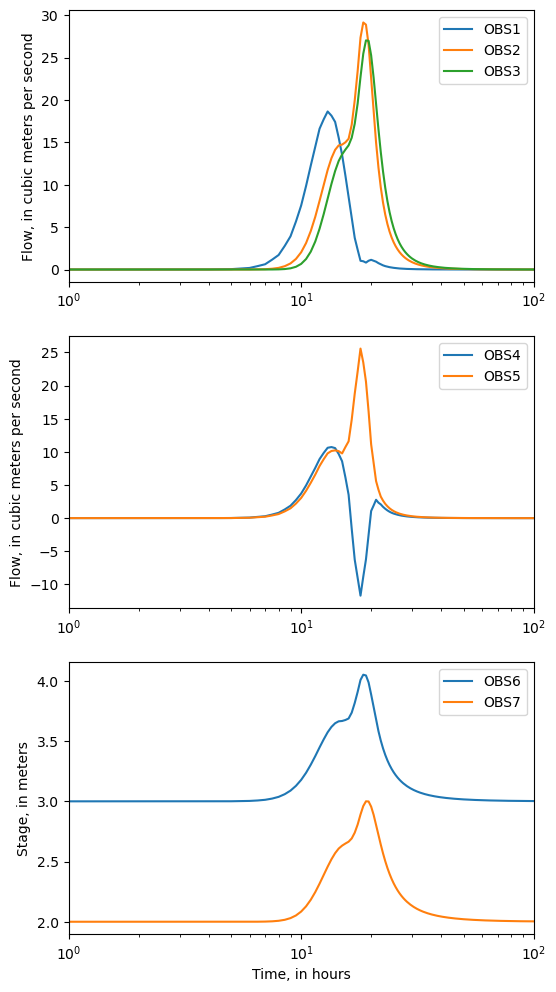

In [9]:
fig = plt.figure(figsize=(6, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.semilogx(times, obs1["flow"], label="OBS1")
ax1.semilogx(times, obs2["flow"], label="OBS2")
ax1.semilogx(times, -obs3["strflow"], label="OBS3")
ax1.set_ylabel("Flow, in cubic meters per second")
ax1.legend()

ax = fig.add_subplot(3, 1, 2, sharex=ax1)
ax.semilogx(times, obs4["flow"], label="OBS4")
ax.semilogx(times, obs5["flow"], label="OBS5")
ax.set_ylabel("Flow, in cubic meters per second")
ax.legend()

ax = fig.add_subplot(3, 1, 3, sharex=ax1)
ax.semilogx(times, obs6["stage"], label="OBS6")
ax.semilogx(times, obs7["stage"], label="OBS7")
ax.set_xlim(1, 100)
ax.set_ylabel("Stage, in meters")
ax.set_xlabel("Time, in hours")
ax.legend();

### Plot simulated water surface profiles

Simulated water surface profiles can be created using the `ModelCrossSection` class. 

Several things that we need in addition to the stage data include reach lengths and bottom elevations. We load these data from an existing file.

In [10]:
sd = np.genfromtxt(os.path.join(datapth, "SWR004.dis.ref"), names=True)

The contents of the file are shown in the cell below.

In [11]:
fc = open(os.path.join(datapth, "SWR004.dis.ref")).readlines()
fc

['   IRCH   RLEN     BELEV\n',
 '      1  1000.       2.0\n',
 '      2   500.      1.83\n',
 '      3   500.      1.83\n',
 '      4  1000.      1.67\n',
 '      5  1000.      1.50\n',
 '      6  1000.      1.33\n',
 '      7  1000.      1.17\n',
 '      8   500.       1.0\n',
 '      9   500.      1.83\n',
 '     10  1118.      1.65\n',
 '     11  1118.      1.41\n',
 '     12  1000.      1.17\n',
 '     13   500.       1.0\n',
 '     14   500.       1.0\n',
 '     15  1000.      0.75\n',
 '     16  1000.      0.50\n',
 '     17  1000.      0.25\n',
 '     18  1000.       0.0']

Create an instance of the `SwrStage` class for SWR Process stage data.

In [12]:
sobj = flopy.utils.SwrStage(os.path.join(datapth, files[3]))

Create a selection condition (`iprof`) that can be used to extract data for the reaches of interest (reaches 0, 1, and 8 through 17). Use this selection condition to extract reach lengths (from `sd['RLEN']`) and the bottom elevation  (from `sd['BELEV']`) for the reaches of interest. The selection condition will also be used to extract the stage data for reaches of interest.

In [13]:
iprof = sd["IRCH"] > 0
iprof[2:8] = False
dx = np.extract(iprof, sd["RLEN"])
belev = np.extract(iprof, sd["BELEV"])

Create a fake model instance so that the `ModelCrossSection` class can be used.

In [14]:
ml = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ml,
    nrow=1,
    ncol=dx.shape[0],
    delr=dx,
    top=4.5,
    botm=belev.reshape(1, 1, 12),
)

Create an array with the x position at the downstream end of each reach, which will be used to color the plots below each reach. 

In [15]:
x = np.cumsum(dx)

Plot simulated water surface profiles for 8 times.

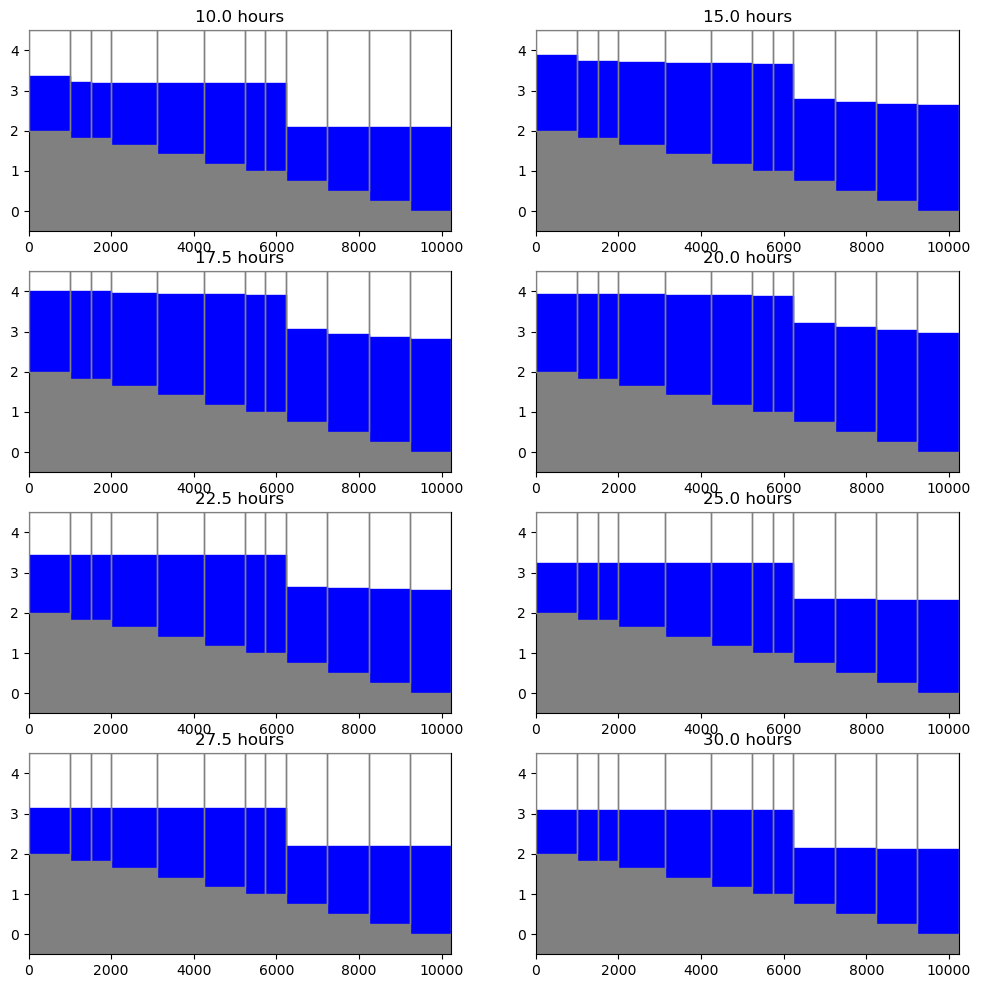

In [16]:
fig = plt.figure(figsize=(12, 12))
for idx, v in enumerate([19, 29, 34, 39, 44, 49, 54, 59]):
    ax = fig.add_subplot(4, 2, idx + 1)
    s = sobj.get_data(idx=v)
    stage = np.extract(iprof, s["stage"])
    xs = flopy.plot.PlotCrossSection(model=ml, line={"Row": 0})
    xs.plot_fill_between(
        stage.reshape(1, 1, 12),
        colors=["none", "blue"],
        ax=ax,
        edgecolors="none",
    )
    linecollection = xs.plot_grid(ax=ax, zorder=10)
    ax.fill_between(
        np.append(0.0, x),
        y1=np.append(belev[0], belev),
        y2=-0.5,
        facecolor="0.5",
        edgecolor="none",
        step="pre",
    )
    ax.set_title("{} hours".format(times[v]))
    ax.set_ylim(-0.5, 4.5)

## Summary

This notebook demonstrates flopy functionality for reading binary output generated by the SWR Process. Binary files that can be read include observations, stages, budgets, flow, reach-aquifer exchanges, and structure data. The binary stage data can also be used to create water-surface profiles.  

Hope this gets you started!